# Analytical Interface Corrections to Ion Dissociation
Amro Dodin - UC Berkeley & LBL

In this notebook, we'll explore the impact of different interfaces on ion pair dissociation.
We'll be focusing on the dissociation of Na Cl as a prototypical example.
As a first step, we'll define the potentials of interest. 
Then, we will plot these for the dissociation of an ion pair conditioned on the anion position.

First, let's load in the required packages. We'll need the following:
    
- numpy
- matplotlib through the pyplot interface


In [279]:
import numpy as np
import matplotlib.pyplot as plt

from numpy import pi, exp, cos, sin, sqrt

plt.rc('font', size=20)

We'll also define some physical constants we'll need:

- $\epsilon_0$: Permitivitty of Free Space
- $k_B T$: Thermal energy at 300K
- $\chi_{\mathrm{water}}$: The relative susceptivility of water

In [254]:
eps_0_nat = 55.26349406     # In units of e^2 eV^-1 micron^-1
eV_to_kCal = 23             # kCal/mol eV^-1
micron_to_angstrom = 1e4    # A micron^-1
eps_0 = eps_0_nat/(eV_to_kCal*micron_to_angstrom)
kT = 0.593                  # kCal/mol
chi_water = 77.4            # Water Relative Permitivity

We'll also define some Lennard-Jones parameters from Na, Cl, and Au (which we'll use for the wall).

In [255]:
epsilon_lj_Na = 0.12466
epsilon_lj_Cl = 0.12466
epsilon_lj_NaCl = sqrt(epsilon_lj_Na * epsilon_lj_Cl)
sigma_lj_Na = 2.87600
sigma_lj_Cl = 3.78500
sigma_lj_Au = 3.16435
sigma_lj_NaCl = (sigma_lj_Na + sigma_lj_Cl)/2
sigma_lj_NaAu = (sigma_lj_Na + sigma_lj_Au)/2

## Potentials

We'll be writing down a bunch of potential energy functions. To help plot them and make sure everything looks correct, it'll be helpful to generate a few sets of points to plot along. 
First, let's generate a 1D array of points along the z axis from 0 to 10 $\AA$

In [304]:
r_1D = np.zeros((100,3))
r_1D[:,2] = np.linspace(1, 10, 100)

Since we'll be interested in studying systems with an interface that breaks symmetry along one dimension, we'll also want a 2D grid of points. By convention, we'll place the interface in the $xy$ plane and use the $z$ coordinate to set the distance to the interface. We'll place the interface at $z=10 \AA$ and generate points in the interval $z\in [-10,10]$


### Pair Potentials

Next let's define the potentials that will contribute to the system's potential energies. First, we'll define the Coulomb and Lennard-Jones Pair potentials.

In [281]:
def coulomb_potential(r1, r2=np.array([[0, 0, 0]]), q1=1, q2=[1], chi=0):
    E_c = 0
    prefactor = 1/(4 * pi * eps_0) * 1/(1 + chi)
    for q, ri in zip(q2, r2):
        r = np.linalg.norm(r1 - ri, axis=1)
        E_c += prefactor * q1*q/r
    return E_c

In [282]:
def lj_potential(r1, r2 = np.array([[0,0,0]]), epsilon=[epsilon_lj_NaCl], sigma=[sigma_lj_NaCl]):
    E_LJ = 0
    for e, s, ri in zip(epsilon, sigma, r2):
        r = np.linalg.norm(r1 - ri, axis=1)/s
        E_LJ += e * (r**-12 - r**-6)
    return E_LJ

Let's plot these pair potentials as a function of distance by scanning along the z axis and generate The probability distribution due to the pair potentials.

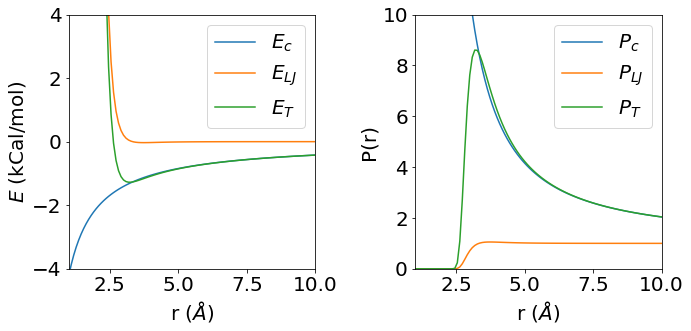

In [302]:
fig,ax = plt.subplots(1, 2, figsize=(10, 5))

V_c = coulomb_potential(r_1D,q2=[-1], chi=chi_water)
ax[0].plot(r_1D[:,2], V_c)

V_lj = lj_potential(r_1)
ax[0].plot(r_1D[:,2], V_lj)

ax[0].plot(r_1D[:,2], V_lj+V_c)
ax[0].set_xlabel('r ($\AA$)')
ax[0].set_ylabel('$E$ (kCal/mol)')
ax[0].legend(['$E_c$', '$E_{LJ}$', '$E_T$'])

ax[0].set_xlim(1, 10)
ax[0].set_ylim(-4, 4)

p_c = np.exp(-(V_c)/kT)
p_LJ = np.exp(-V_lj/kT)
p_T = np.exp(-(V_lj+V_c)/kT)
ax[1].plot(r_1D[:,2], p_c)
ax[1].plot(r_1D[:,2], p_LJ)
ax[1].plot(r_1D[:,2], p_T)
ax[1].set_xlabel('r ($\AA$)')
ax[1].set_ylabel('P(r)')

ax[1].legend(['$P_c$', '$P_{LJ}$', '$P_T$'])

ax[1].set_xlim(1, 10)
ax[1].set_ylim(0,10)

plt.tight_layout()
plt.show()

## Wall Potentials

The next step is to implement the influence of the wall on the ion positions. The walls have two primary effects: direct repulsive effects due to a Lennard-Jones potentials and indirect coulombic effects due to the build up of charge at the dielectric continuity.
We can easily write down the Lennard-Jones potential along any dimension by writing down a 1D potential as follows:

In [283]:
def lj_wall_potential(r_1, z_wall = 0, epsilon=epsilon_lj_NaCl, sigma=sigma_lj_NaAu, dimension=2):
    r = (r_1[:, dimension] - z_wall)/sigma
    return epsilon * (r**-12 - r**-6)

In [259]:
def conductor_wall_potential_other(r_1, z_wall, q1=1, r_2= np.array([0, 0, 0]), q2=1, chi=0):
    z_im = 2*z_wall - r_2[2]
    r_im = r_2.copy()
    r_im[2] = z_im
    print(r_im)
    return coulomb_potential(r_1, r_im, q1, -q2, chi)

In [260]:
def dielectric_wall_potential_other(r_1, z_wall, q1=1, r_2= np.array([0, 0, 0]), q2=1, chi=0, chi2=0):
    z_im = 2*z_wall - r_2[2]
    r_im = r_2.copy()
    r_im[2] = z_im
    deltachi = chi - chi2
    q = q2*deltachi/(2+deltachi)
    print(q)
    return coulomb_potential(r_1, r_im, q, chi)

In [261]:
def conductor_wall_potential(r_1, z_wall, q=1, chi=0):
    dz = 2*(r_1[:, 2] - z_wall)
    prefactor = 1/(4 * pi * eps_0) * 1/(1 + chi)
    V = prefactor * q**2/dz
    V = V * (dz <0)
    return V

In [262]:
def dielectric_wall_potential(r_1, z_wall, q=1, chi=0, chi2=0):
    dz = 2*(r_1[:, 2] - z_wall)
    prefactor = 1/(4 * pi * eps_0) * 1/(1 + chi)
    deltachi = chi - chi2
    q = q*deltachi/(2+deltachi)
    V = prefactor * q**2/dz
    #V = V * (dz <0)
    return V

In [265]:
n_x = 100
n_z = 100

x_min = -20
x_max = 20
z_min = -10
z_max = 10

x = np.linspace(x_min, x_max, n_x)
z = np.linspace(z_min, z_max, n_z)

X, Z = np.meshgrid(x, z)
Y = np.zeros_like(X)
r_2D = np.reshape([X, Y, Z], (3, n_x*n_z)).T

r_cat = np.array([0, 0, 7])
z_wall=10


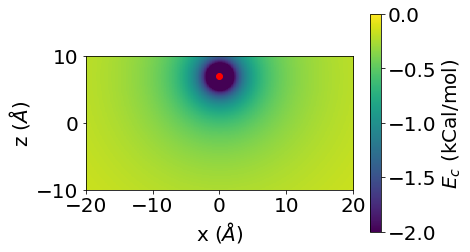

In [266]:
V_c_2D = coulomb_potential(r_2D, chi=chi, r_2=r_cat, q=-1)
V_c_2D = np.reshape(V_c_2D, (n_x, n_z))
im = plt.imshow(V_c_2D, extent=[x_min, x_max, z_min, z_max], origin='lower', aspect='equal', vmin=-2, vmax=0)
plt.colorbar(im, label='$E_c$ (kCal/mol)')
plt.scatter(r_cat[0], r_cat[2], c='r')
plt.xlabel('x ($\AA$)')
plt.ylabel('z ($\AA$)')
plt.show()

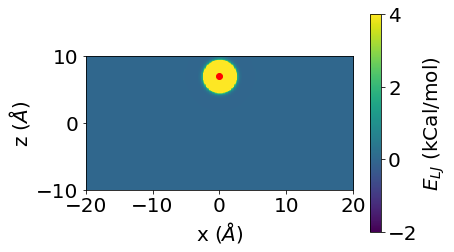

In [267]:
V_lj_2D = lj_potential(r_2D, r_2=r_cat)
V_lj_2D = np.reshape(V_lj_2D, (n_x, n_z))
im = plt.imshow(V_lj_2D, extent=[x_min, x_max, z_min, z_max],origin='lower', aspect='equal', vmin=-2, vmax=4)
plt.colorbar(im, label='$E_{LJ}$ (kCal/mol)')
plt.scatter(r_cat[0], r_cat[2], c='r')
plt.xlabel('x ($\AA$)')
plt.ylabel('z ($\AA$)')
plt.show()

/var/folders/l1/h3x9q50j7593jnfkgtq065t80000gn/T/ipykernel_31768/3036887493.py:3: RuntimeWarning: divide by zero encountered in power
  return epsilon * (r**-12 - r**-6)
/var/folders/l1/h3x9q50j7593jnfkgtq065t80000gn/T/ipykernel_31768/3036887493.py:3: RuntimeWarning: invalid value encountered in subtract
  return epsilon * (r**-12 - r**-6)


Text(0, 0.5, 'z ($\\AA$)')

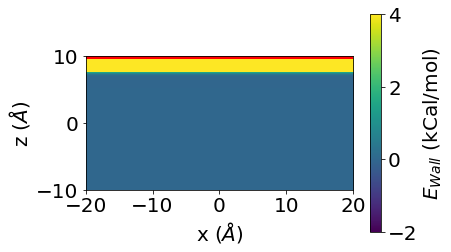

In [268]:
V_wall_2D = lj_wall_potential(r_2D, r_2=z_wall)
V_wall_2D = np.reshape(V_wall_2D, (n_x, n_z))
im = plt.imshow(V_wall_2D, extent=[x_min, x_max, z_min, z_max], origin='lower', aspect='equal', vmin=-2, vmax=4)
plt.colorbar(im, label='$E_{Wall}$ (kCal/mol)')
plt.axhline(10, c='r', lw=5)
plt.xlabel('x ($\AA$)')
plt.ylabel('z ($\AA$)')

[ 0  0 13]


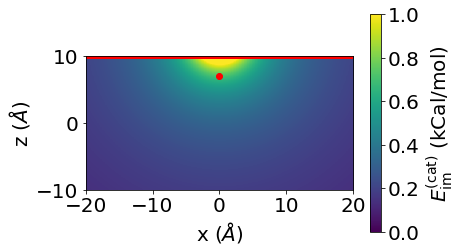

In [269]:
V_cond_2D = conductor_wall_potential_other(r_2D, z_wall, chi=chi, r_2=r_cat, q=-1)
V_cond_2D = np.reshape(V_cond_2D, (n_x, n_z))
im = plt.imshow(V_cond_2D, extent=[x_min, x_max, z_min, z_max], origin='lower', aspect='equal', vmin=0, vmax=1)
plt.colorbar(im, label='$E^{\mathrm{(cat)}}_{\mathrm{im}}$ (kCal/mol)')
plt.axhline(10, c='r', lw=5)
plt.scatter(r_cat[0], r_cat[2], c='r')
plt.xlabel('x ($\AA$)')
plt.ylabel('z ($\AA$)')
plt.show()

Text(0, 0.5, 'z ($\\AA$)')

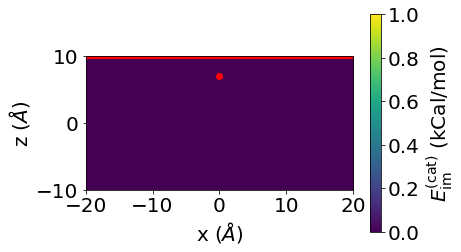

In [275]:
V_diel_2D = dielectric_wall_potential_other(r_2D, z_wall, chi=chi, r_2=r_cat, q=-1)
V_diel_2D = np.reshape(V_diel_2D, (n_x, n_z))
im = plt.imshow(V_diel_2D, extent=[x_min, x_max, z_min, z_max], origin='lower', aspect='equal', vmin=0, vmax=1)
plt.colorbar(im, label='$E^{\mathrm{(cat)}}_{\mathrm{im}}$ (kCal/mol)')
plt.axhline(10, c='r', lw=5)
plt.scatter(r_cat[0], r_cat[2], c='r')
plt.xlabel('x ($\AA$)')
plt.ylabel('z ($\AA$)')

/var/folders/l1/h3x9q50j7593jnfkgtq065t80000gn/T/ipykernel_31768/4132776012.py:4: RuntimeWarning: divide by zero encountered in true_divide
  V = prefactor * q**2/dz
/var/folders/l1/h3x9q50j7593jnfkgtq065t80000gn/T/ipykernel_31768/4132776012.py:5: RuntimeWarning: invalid value encountered in multiply
  V = V * (dz <0)


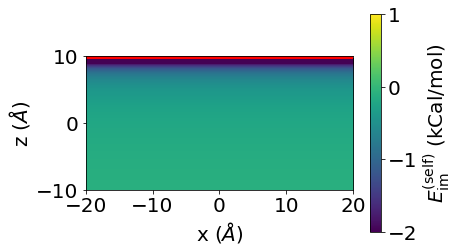

In [271]:
V_cond_2D_self = conductor_wall_potential(r_2D, z_wall, chi=chi,q=1)
V_cond_2D_self = np.reshape(V_cond_2D_self, (n_x, n_z))
im = plt.imshow(V_cond_2D_self, extent=[x_min, x_max, z_min, z_max], origin='lower', aspect='equal', vmin=-2, vmax=1)
plt.colorbar(im, label='$E^{\mathrm{(self)}}_{\mathrm{im}}$ (kCal/mol)')
plt.axhline(10, c='r', lw=5)
plt.xlabel('x ($\AA$)')
plt.ylabel('z ($\AA$)')
plt.show()

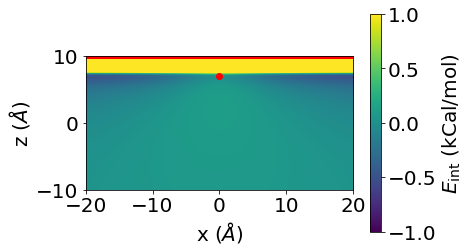

In [272]:
V_int_2D = V_wall_2D + V_cond_2D + V_cond_2D_self
im = plt.imshow(V_int_2D, extent=[x_min, x_max, z_min, z_max], origin='lower', aspect='equal', vmin=-1, vmax=1)
plt.colorbar(im, label='$E_{\mathrm{int}}$ (kCal/mol)')
plt.axhline(10, c='r', lw=5)
plt.scatter(r_cat[0], r_cat[2], c='r')
plt.xlabel('x ($\AA$)')
plt.ylabel('z ($\AA$)')
plt.show()

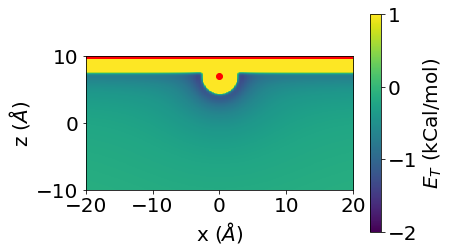

In [273]:
V_T_2D = V_lj_2D + V_wall_2D + V_c_2D + V_cond_2D + V_cond_2D_self
im = plt.imshow(V_T_2D, extent=[x_min, x_max, z_min, z_max], origin='lower', aspect='equal', vmin=-2, vmax=1)
plt.colorbar(im, label='$E_T$ (kCal/mol)')
plt.axhline(10, c='r', lw=5)
plt.scatter(r_cat[0], r_cat[2], c='r')
plt.xlabel('x ($\AA$)')
plt.ylabel('z ($\AA$)')
plt.show()

Text(0, 0.5, 'z ($\\AA$)')

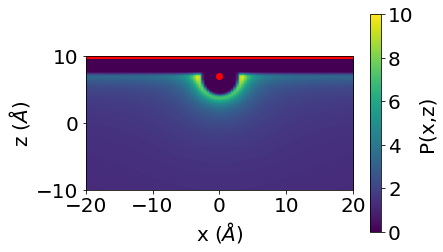

In [274]:
p_2D = exp(-V_T_2D/kT)
im = plt.imshow(p_2D, extent=[x_min, x_max, z_min, z_max], origin='lower', aspect='equal', vmin=0, vmax=10)
plt.colorbar(im, label='P(x,z)')
plt.axhline(10, c='r', lw=5)
plt.scatter(r_cat[0], r_cat[2], c='r')
plt.xlabel('x ($\AA$)')
plt.ylabel('z ($\AA$)')